In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import gc

In [2]:
from prj.config import DATA_DIR


BASE_PATH = DATA_DIR  / 'train'
partition = 4
train_ds = pl.concat([
    pl.scan_parquet(BASE_PATH / f'partition_id={i}' / 'part-0.parquet')
    for i in range(partition, partition + 1)
]).collect()

In [3]:
parts = pl.concat([
    pl.scan_parquet(BASE_PATH / f'partition_id={i}' / 'part-0.parquet') \
        .select(['date_id', 'time_id', 'symbol_id']) \
        .with_columns(pl.lit(i).cast(pl.Int8).alias('part')).collect()
    for i in range(10)
])
parts.head()

shape: (5, 4)
┌─────────┬─────────┬───────────┬──────┐
│ date_id ┆ time_id ┆ symbol_id ┆ part │
│ ---     ┆ ---     ┆ ---       ┆ ---  │
│ i16     ┆ i16     ┆ i8        ┆ i8   │
╞═════════╪═════════╪═══════════╪══════╡
│ 0       ┆ 0       ┆ 1         ┆ 0    │
│ 0       ┆ 0       ┆ 7         ┆ 0    │
│ 0       ┆ 0       ┆ 9         ┆ 0    │
│ 0       ┆ 0       ┆ 10        ┆ 0    │
│ 0       ┆ 0       ┆ 14        ┆ 0    │
└─────────┴─────────┴───────────┴──────┘

In [4]:
responders = train_ds.select(['date_id', 'time_id', 'symbol_id'] + [f'responder_{i}' for i in range(9)])
responders.head()

shape: (5, 12)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0          ┆   ┆ 5          ┆ 6          ┆ _7        ┆ _8        │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆ f32        ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 680     ┆ 0       ┆ 0         ┆ -0.304665  ┆ … ┆ 0.375675   ┆ 0.929775   ┆ -1.574939 ┆ 1.101371  │
│ 680     ┆ 0       ┆ 1         ┆ 0.089769   ┆ … ┆ 0.777026   ┆ 0.826995   ┆ 0.569681  ┆ 1.986971  │
│ 680     ┆ 0       ┆ 2         ┆ 0.218281   ┆ … ┆ -0.123519  ┆ -0.296969  ┆ 0.547286  ┆ -0.049303 │
│ 680     ┆ 0       ┆ 3         ┆ -0.012298  ┆ … ┆ 0.718955   ┆ 2.047506   ┆ 3.691308  ┆ 3.031337  │
│ 680     ┆ 0       ┆ 5         ┆ -0.229585  ┆ … ┆ 1.016049   ┆ 0.103898   ┆ 0.814866  ┆ 2.07328   │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

In [5]:
train_ds.null_count().transpose(include_header=True).rename({'column_0': 'null_count'}).with_columns(
    pl.col('null_count').truediv(train_ds.shape[0]).mul(100).alias('null_count_pct')
).sort('null_count', descending=True).head(10)

shape: (10, 3)
┌────────────┬────────────┬────────────────┐
│ column     ┆ null_count ┆ null_count_pct │
│ ---        ┆ ---        ┆ ---            │
│ str        ┆ u32        ┆ f64            │
╞════════════╪════════════╪════════════════╡
│ feature_39 ┆ 353062     ┆ 7.028974       │
│ feature_42 ┆ 353062     ┆ 7.028974       │
│ feature_50 ┆ 352852     ┆ 7.024793       │
│ feature_53 ┆ 352852     ┆ 7.024793       │
│ feature_15 ┆ 124539     ┆ 2.479399       │
│ feature_41 ┆ 93611      ┆ 1.863665       │
│ feature_44 ┆ 93611      ┆ 1.863665       │
│ feature_52 ┆ 93402      ┆ 1.859504       │
│ feature_55 ┆ 93402      ┆ 1.859504       │
│ feature_73 ┆ 50457      ┆ 1.004529       │
└────────────┴────────────┴────────────────┘

In [6]:
lags = pl.read_parquet(DATA_DIR / 'lags/date_id=0/part-0.parquet')
lags.head()

shape: (5, 12)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0_lag_1    ┆   ┆ 5_lag_1    ┆ 6_lag_1    ┆ _7_lag_1  ┆ _8_lag_1  │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆ f32        ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 0       ┆ 0       ┆ 0         ┆ -0.442215  ┆ … ┆ -0.036595  ┆ -1.305746  ┆ -0.795677 ┆ -0.143724 │
│ 0       ┆ 0       ┆ 1         ┆ -0.651829  ┆ … ┆ -0.615652  ┆ -1.162801  ┆ -1.205924 ┆ -1.245934 │
│ 0       ┆ 0       ┆ 2         ┆ -0.656373  ┆ … ┆ -0.378265  ┆ -1.57429   ┆ -1.863071 ┆ -0.027343 │
│ 0       ┆ 0       ┆ 3         ┆ -0.188186  ┆ … ┆ -0.054984  ┆ 0.329152   ┆ -0.965471 ┆ 0.576635  │
│ 0       ┆ 0       ┆ 4         ┆ -0.257462  ┆ … ┆ -0.597093  ┆ 0.219856   ┆ -0.276356 ┆ -0.90479  │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

# Basic

In [7]:
parts.group_by('part').agg(
    pl.col('date_id').min().alias('min_date_id'),
    pl.col('date_id').max().alias('max_date_id'),
    pl.col('date_id').count().alias('num_samples')
)

shape: (10, 4)
┌──────┬─────────────┬─────────────┬─────────────┐
│ part ┆ min_date_id ┆ max_date_id ┆ num_samples │
│ ---  ┆ ---         ┆ ---         ┆ ---         │
│ i8   ┆ i16         ┆ i16         ┆ u32         │
╞══════╪═════════════╪═════════════╪═════════════╡
│ 0    ┆ 0           ┆ 169         ┆ 1944210     │
│ 1    ┆ 170         ┆ 339         ┆ 2804247     │
│ 2    ┆ 340         ┆ 509         ┆ 3036873     │
│ 3    ┆ 510         ┆ 679         ┆ 4016784     │
│ 4    ┆ 680         ┆ 849         ┆ 5022952     │
│ 5    ┆ 850         ┆ 1019        ┆ 5348200     │
│ 6    ┆ 1020        ┆ 1189        ┆ 6203912     │
│ 7    ┆ 1190        ┆ 1359        ┆ 6335560     │
│ 8    ┆ 1360        ┆ 1529        ┆ 6140024     │
│ 9    ┆ 1530        ┆ 1698        ┆ 6274576     │
└──────┴─────────────┴─────────────┴─────────────┘

In [8]:
symbol_stats = parts.group_by('symbol_id').agg(
    pl.col('date_id').min().alias('min_date_id'),
    pl.col('date_id').max().alias('max_date_id'),
    pl.col('date_id').n_unique().alias('num_dates'),
    pl.col('date_id').count().alias('num_samples'),
).sort('symbol_id')
symbol_stats.head()

shape: (5, 5)
┌───────────┬─────────────┬─────────────┬───────────┬─────────────┐
│ symbol_id ┆ min_date_id ┆ max_date_id ┆ num_dates ┆ num_samples │
│ ---       ┆ ---         ┆ ---         ┆ ---       ┆ ---         │
│ i8        ┆ i16         ┆ i16         ┆ u32       ┆ u32         │
╞═══════════╪═════════════╪═════════════╪═══════════╪═════════════╡
│ 0         ┆ 1           ┆ 1698        ┆ 1592      ┆ 1468466     │
│ 1         ┆ 0           ┆ 1698        ┆ 1678      ┆ 1543979     │
│ 2         ┆ 1           ┆ 1698        ┆ 1606      ┆ 1484398     │
│ 3         ┆ 2           ┆ 1698        ┆ 1565      ┆ 1446495     │
│ 4         ┆ 952         ┆ 1698        ┆ 706       ┆ 683408      │
└───────────┴─────────────┴─────────────┴───────────┴─────────────┘

Text(0.5, 1.0, 'Number of samples for each stock')

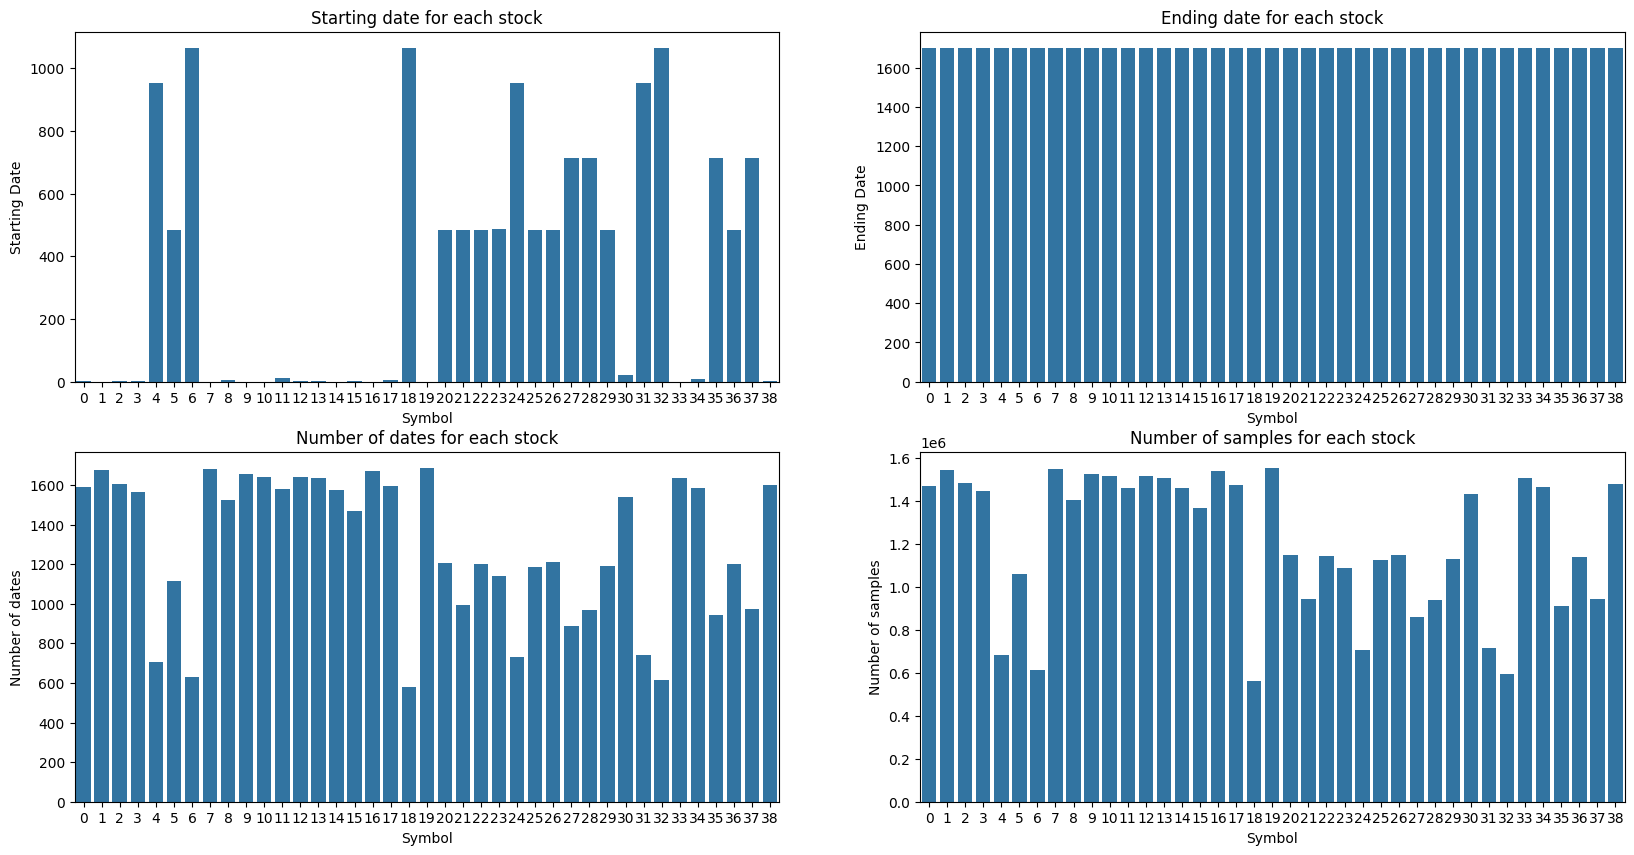

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()

sns.barplot(ax=axes[0], x=symbol_stats['symbol_id'].to_numpy(), y=symbol_stats['min_date_id'].to_numpy())
axes[0].set_xlabel('Symbol')
axes[0].set_ylabel('Starting Date')
axes[0].set_title('Starting date for each stock')

sns.barplot(ax=axes[1], x=symbol_stats['symbol_id'].to_numpy(), y=symbol_stats['max_date_id'].to_numpy())
axes[1].set_xlabel('Symbol')
axes[1].set_ylabel('Ending Date')
axes[1].set_title('Ending date for each stock')

sns.barplot(ax=axes[2], x=symbol_stats['symbol_id'].to_numpy(), y=symbol_stats['num_dates'].to_numpy())
axes[2].set_xlabel('Symbol')
axes[2].set_ylabel('Number of dates')
axes[2].set_title('Number of dates for each stock')

sns.barplot(ax=axes[3], x=symbol_stats['symbol_id'].to_numpy(), y=symbol_stats['num_samples'].to_numpy())
axes[3].set_xlabel('Symbol')
axes[3].set_ylabel('Number of samples')
axes[3].set_title('Number of samples for each stock')

# Basic Correlations

In [10]:
correlations = train_ds.drop(['date_id', 'time_id', 'symbol_id', 'weight']).drop_nulls().corr()
correlations.head()

shape: (5, 88)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ feature_0 ┆ feature_0 ┆ feature_0 ┆ feature_0 ┆ … ┆ responder ┆ responder ┆ responder ┆ responde │
│ 0         ┆ 1         ┆ 2         ┆ 3         ┆   ┆ _5        ┆ _6        ┆ _7        ┆ r_8      │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 1.0       ┆ 0.072724  ┆ 0.892697  ┆ 0.895103  ┆ … ┆ 0.004619  ┆ 0.01097   ┆ 0.023833  ┆ 0.005337 │
│ 0.072724  ┆ 1.0       ┆ -0.032226 ┆ -0.01921  ┆ … ┆ -0.011775 ┆ -0.016418 ┆ -0.02234  ┆ -0.01069 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 6        │
│ 0.892697  ┆ -0.032226 ┆ 1.0       ┆ 0.899749  ┆ … ┆ 0.007359  ┆ 0.015142  ┆ 0.028415  ┆ 0.007906 │
│ 0.895103  ┆ -0.01921  ┆ 0.899749  ┆ 1.0       ┆ … ┆ 0.005427  ┆ 0.012681  ┆ 0.026578  ┆ 0.005935 │
│ 0.031809  ┆ 0.268386  ┆ -0.037401 ┆ 0.005594  ┆ … ┆ -0.027441 ┆ -0.038464 ┆ -0.025571 ┆ -0.02902 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 8        │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

<Axes: >

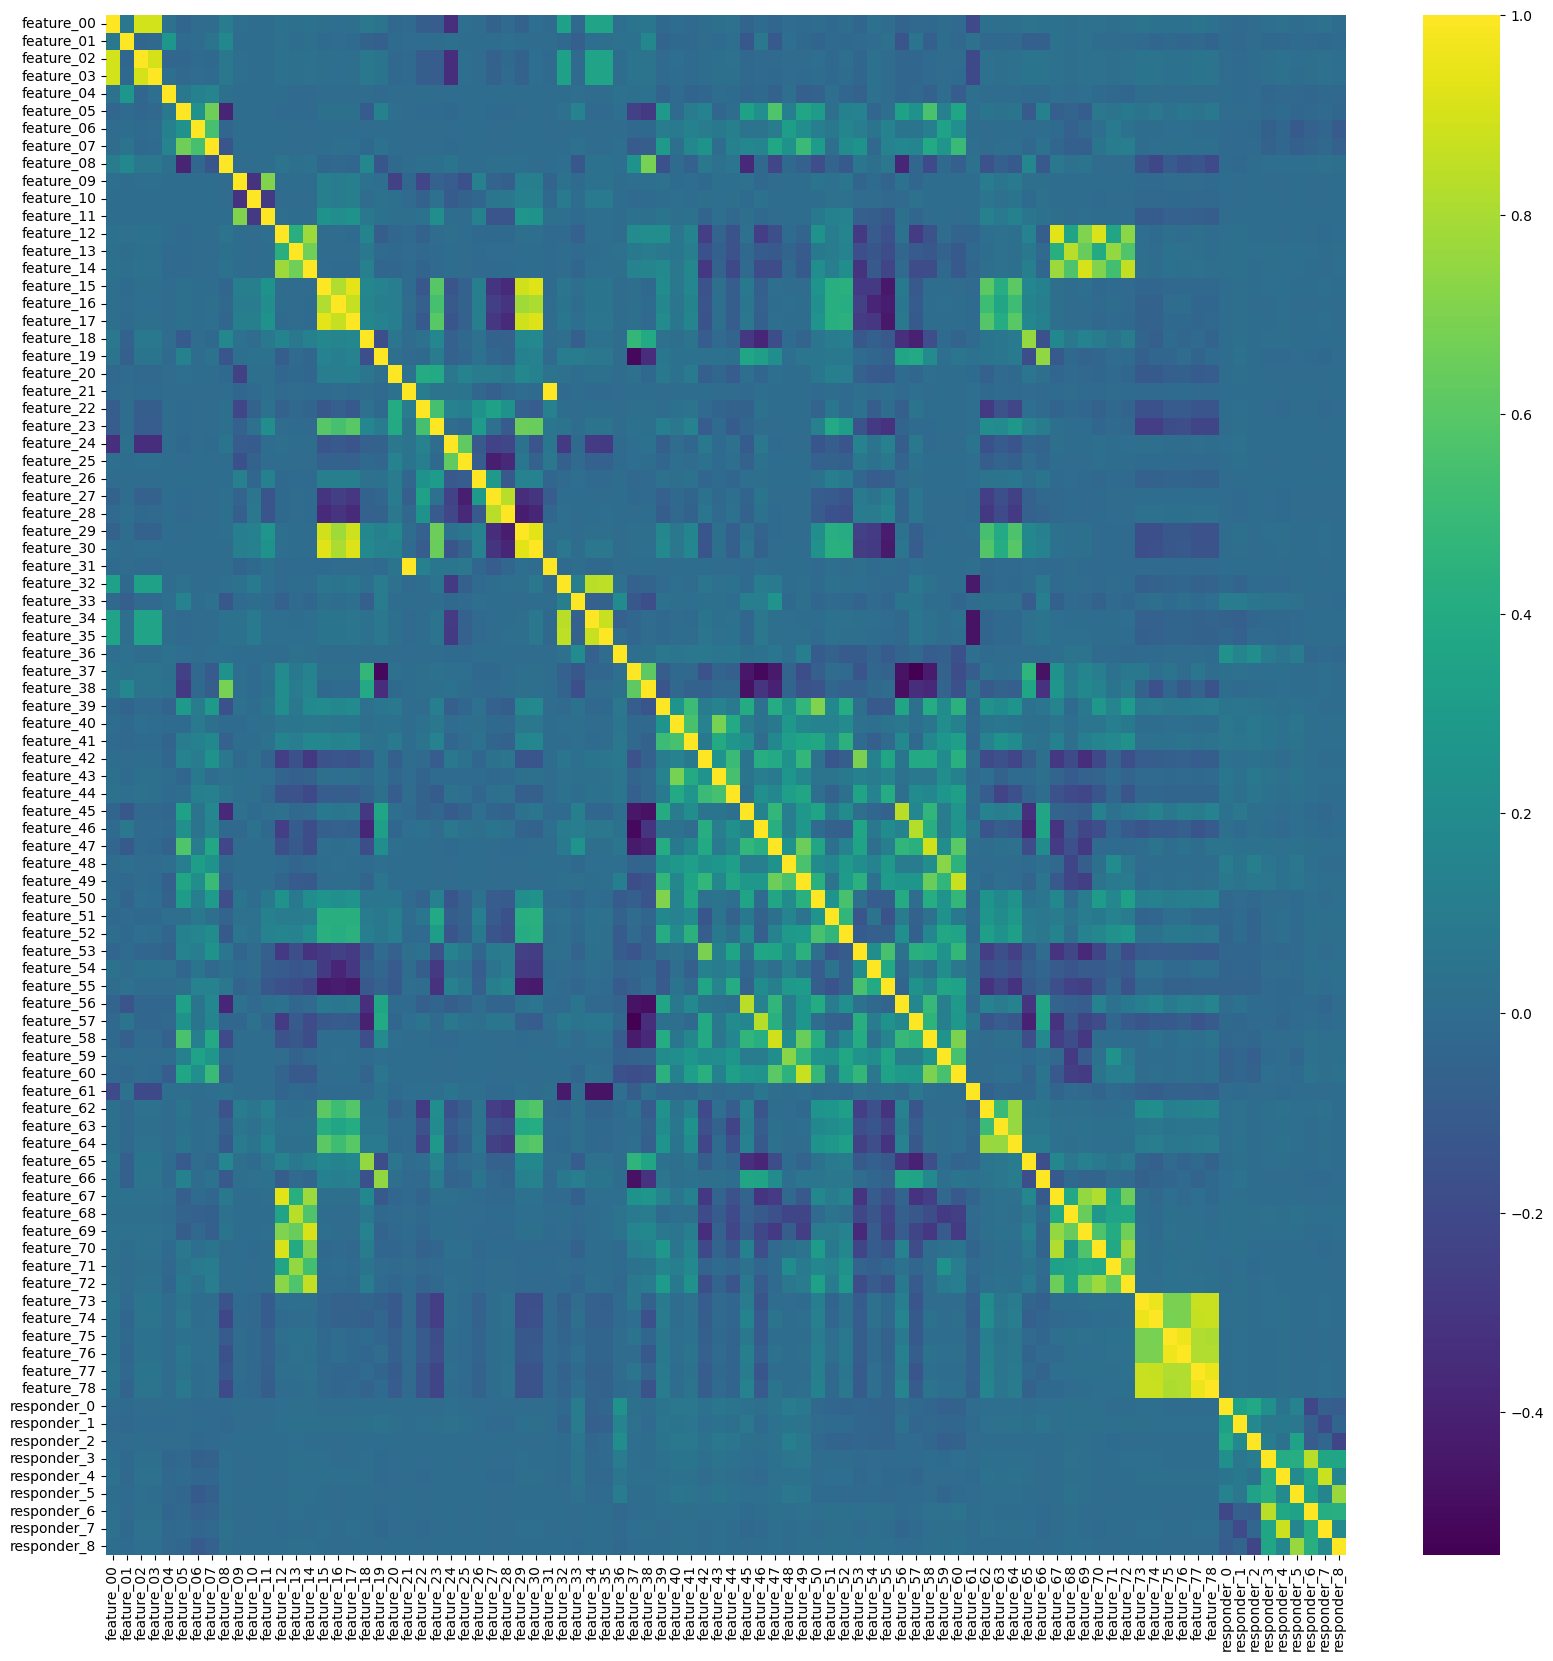

In [11]:
correlations = correlations.to_pandas()
correlations.index = correlations.columns.values

plt.figure(figsize=(20, 20))
sns.heatmap(correlations, cmap='viridis')

<Axes: >

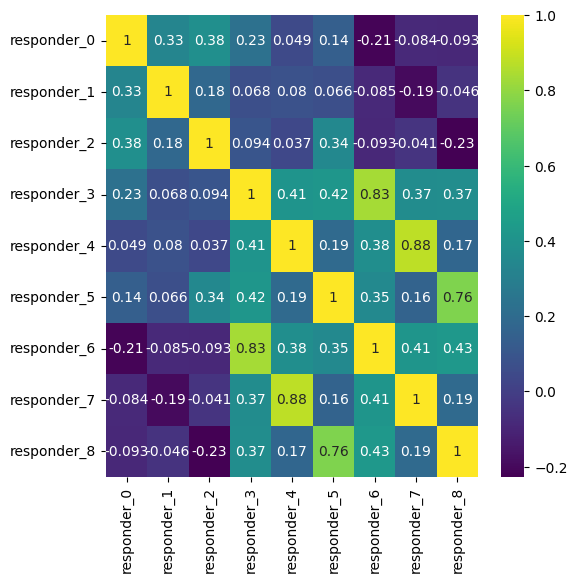

In [12]:
plt.figure(figsize=(6, 6))
sns.heatmap(correlations.iloc[-9:, -9:], cmap='viridis', annot=True)

Responder 6 and 3 are higly correlated

In [13]:
responders_tags = pl.read_csv(DATA_DIR / 'responders.csv')
responders_tags

shape: (9, 6)
┌─────────────┬───────┬───────┬───────┬───────┬───────┐
│ responder   ┆ tag_0 ┆ tag_1 ┆ tag_2 ┆ tag_3 ┆ tag_4 │
│ ---         ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---   │
│ str         ┆ bool  ┆ bool  ┆ bool  ┆ bool  ┆ bool  │
╞═════════════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ responder_0 ┆ true  ┆ false ┆ true  ┆ false ┆ false │
│ responder_1 ┆ true  ┆ false ┆ false ┆ true  ┆ false │
│ responder_2 ┆ true  ┆ true  ┆ false ┆ false ┆ false │
│ responder_3 ┆ false ┆ false ┆ true  ┆ false ┆ true  │
│ responder_4 ┆ false ┆ false ┆ false ┆ true  ┆ true  │
│ responder_5 ┆ false ┆ true  ┆ false ┆ false ┆ true  │
│ responder_6 ┆ false ┆ false ┆ true  ┆ false ┆ false │
│ responder_7 ┆ false ┆ false ┆ false ┆ true  ┆ false │
│ responder_8 ┆ false ┆ true  ┆ false ┆ false ┆ false │
└─────────────┴───────┴───────┴───────┴───────┴───────┘

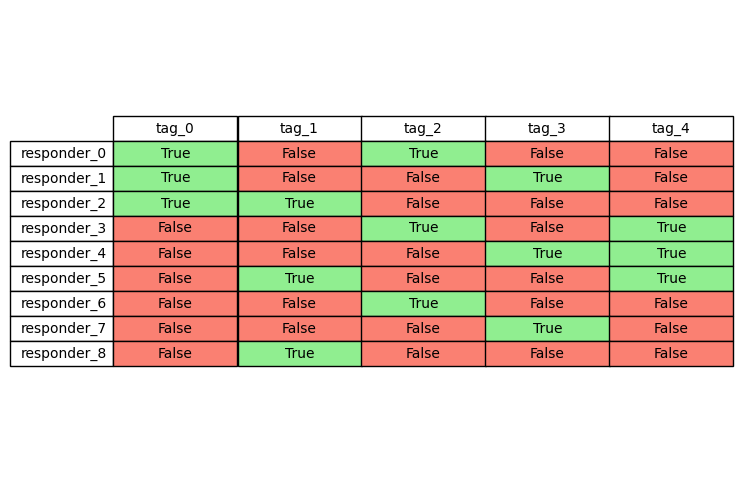

In [14]:
data = responders_tags.to_numpy()[:, 1:]

row_names = responders_tags['responder'].to_list()
col_names = responders_tags.columns[1:]

colors = np.where(data, "lightgreen", "salmon")

fig, ax = plt.subplots(figsize=(8, 6))
ax.axis("tight")
ax.axis("off")
cell_text = np.where(data, "True", "False")
table = ax.table(
    cellText=cell_text,
    cellColours=colors,
    rowLabels=row_names,
    colLabels=col_names,
    loc="center",
    cellLoc="center"
)
table.scale(1, 1.5)
plt.show()


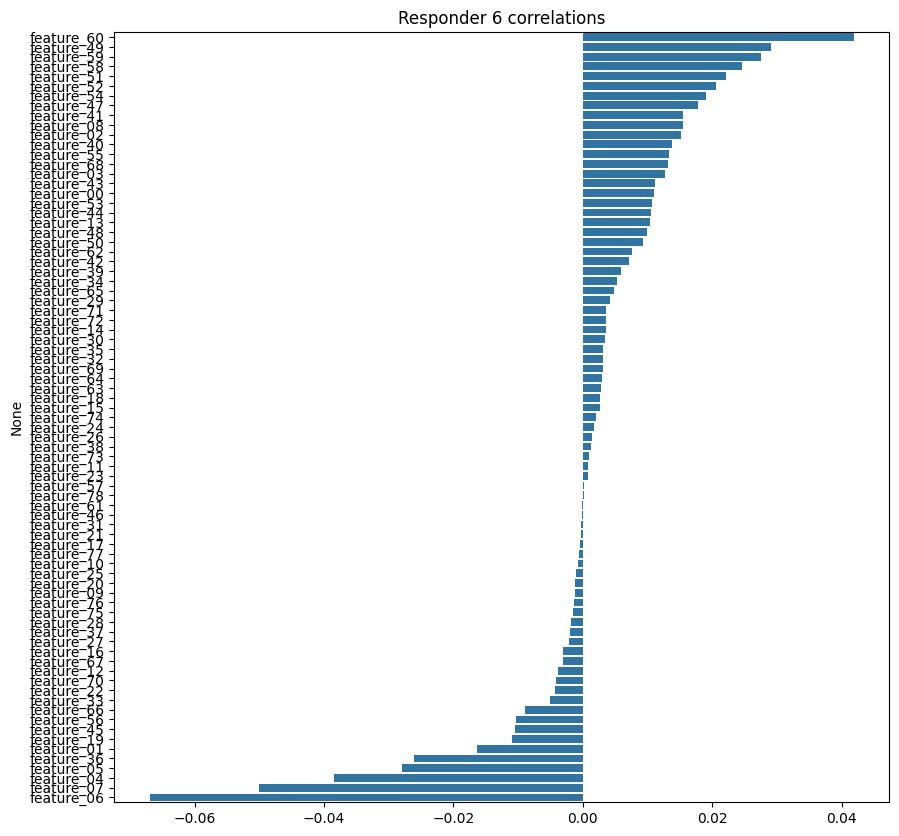

In [15]:
responder_6_correlations = correlations['responder_6'][:-9].sort_values(ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(y=responder_6_correlations.index, x=responder_6_correlations.values)
plt.title('Responder 6 correlations');

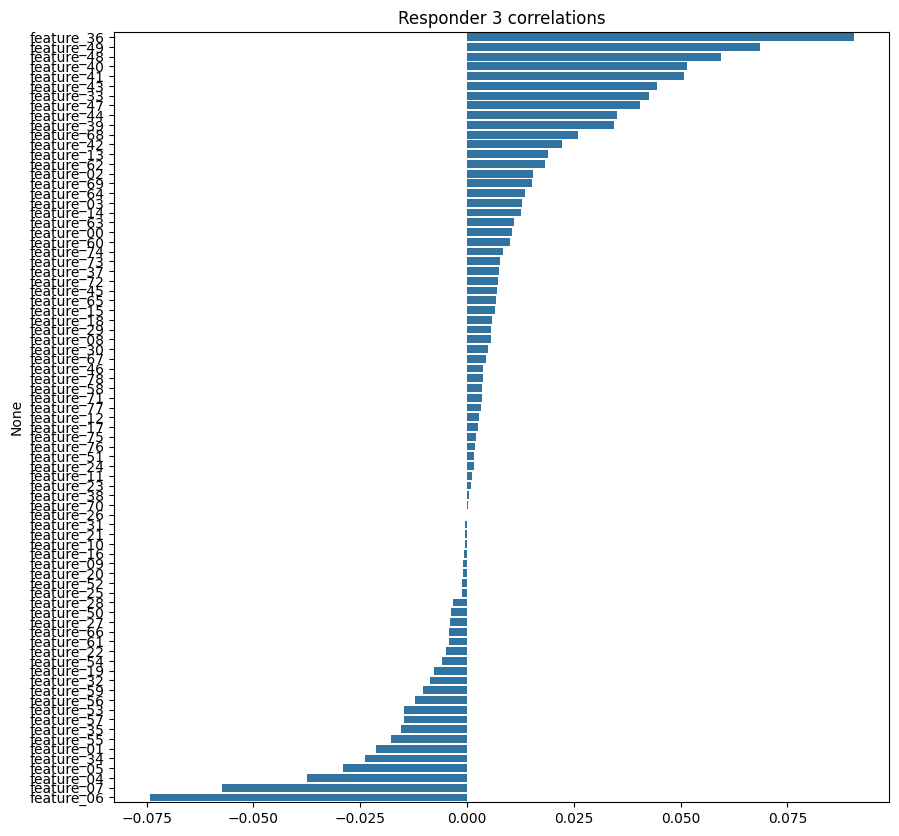

In [16]:
responder_3_correlations = correlations['responder_3'][:-9].sort_values(ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(y=responder_3_correlations.index, x=responder_3_correlations.values)
plt.title('Responder 3 correlations');

# Responders

In [17]:
RESPONDERS = [f'responder_{i}' for i in range(9)]

In [18]:
stock_1_responders = responders.filter(pl.col('symbol_id') == 1)
stock_1_responders.head(3)

shape: (3, 12)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0          ┆   ┆ 5          ┆ 6          ┆ _7        ┆ _8        │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆ f32        ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 680     ┆ 0       ┆ 1         ┆ 0.089769   ┆ … ┆ 0.777026   ┆ 0.826995   ┆ 0.569681  ┆ 1.986971  │
│ 680     ┆ 1       ┆ 1         ┆ 0.048338   ┆ … ┆ 0.624842   ┆ 0.371351   ┆ 0.473043  ┆ 0.969761  │
│ 680     ┆ 2       ┆ 1         ┆ -0.010334  ┆ … ┆ 0.39211    ┆ 0.579337   ┆ 0.673602  ┆ 0.6694    │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

<Axes: ylabel='Count'>

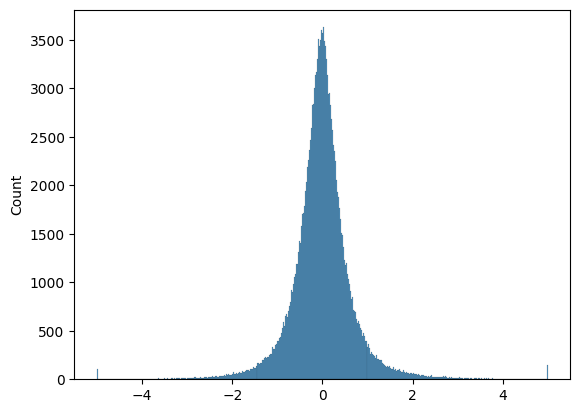

In [19]:
sns.histplot(stock_1_responders['responder_6'].to_numpy())

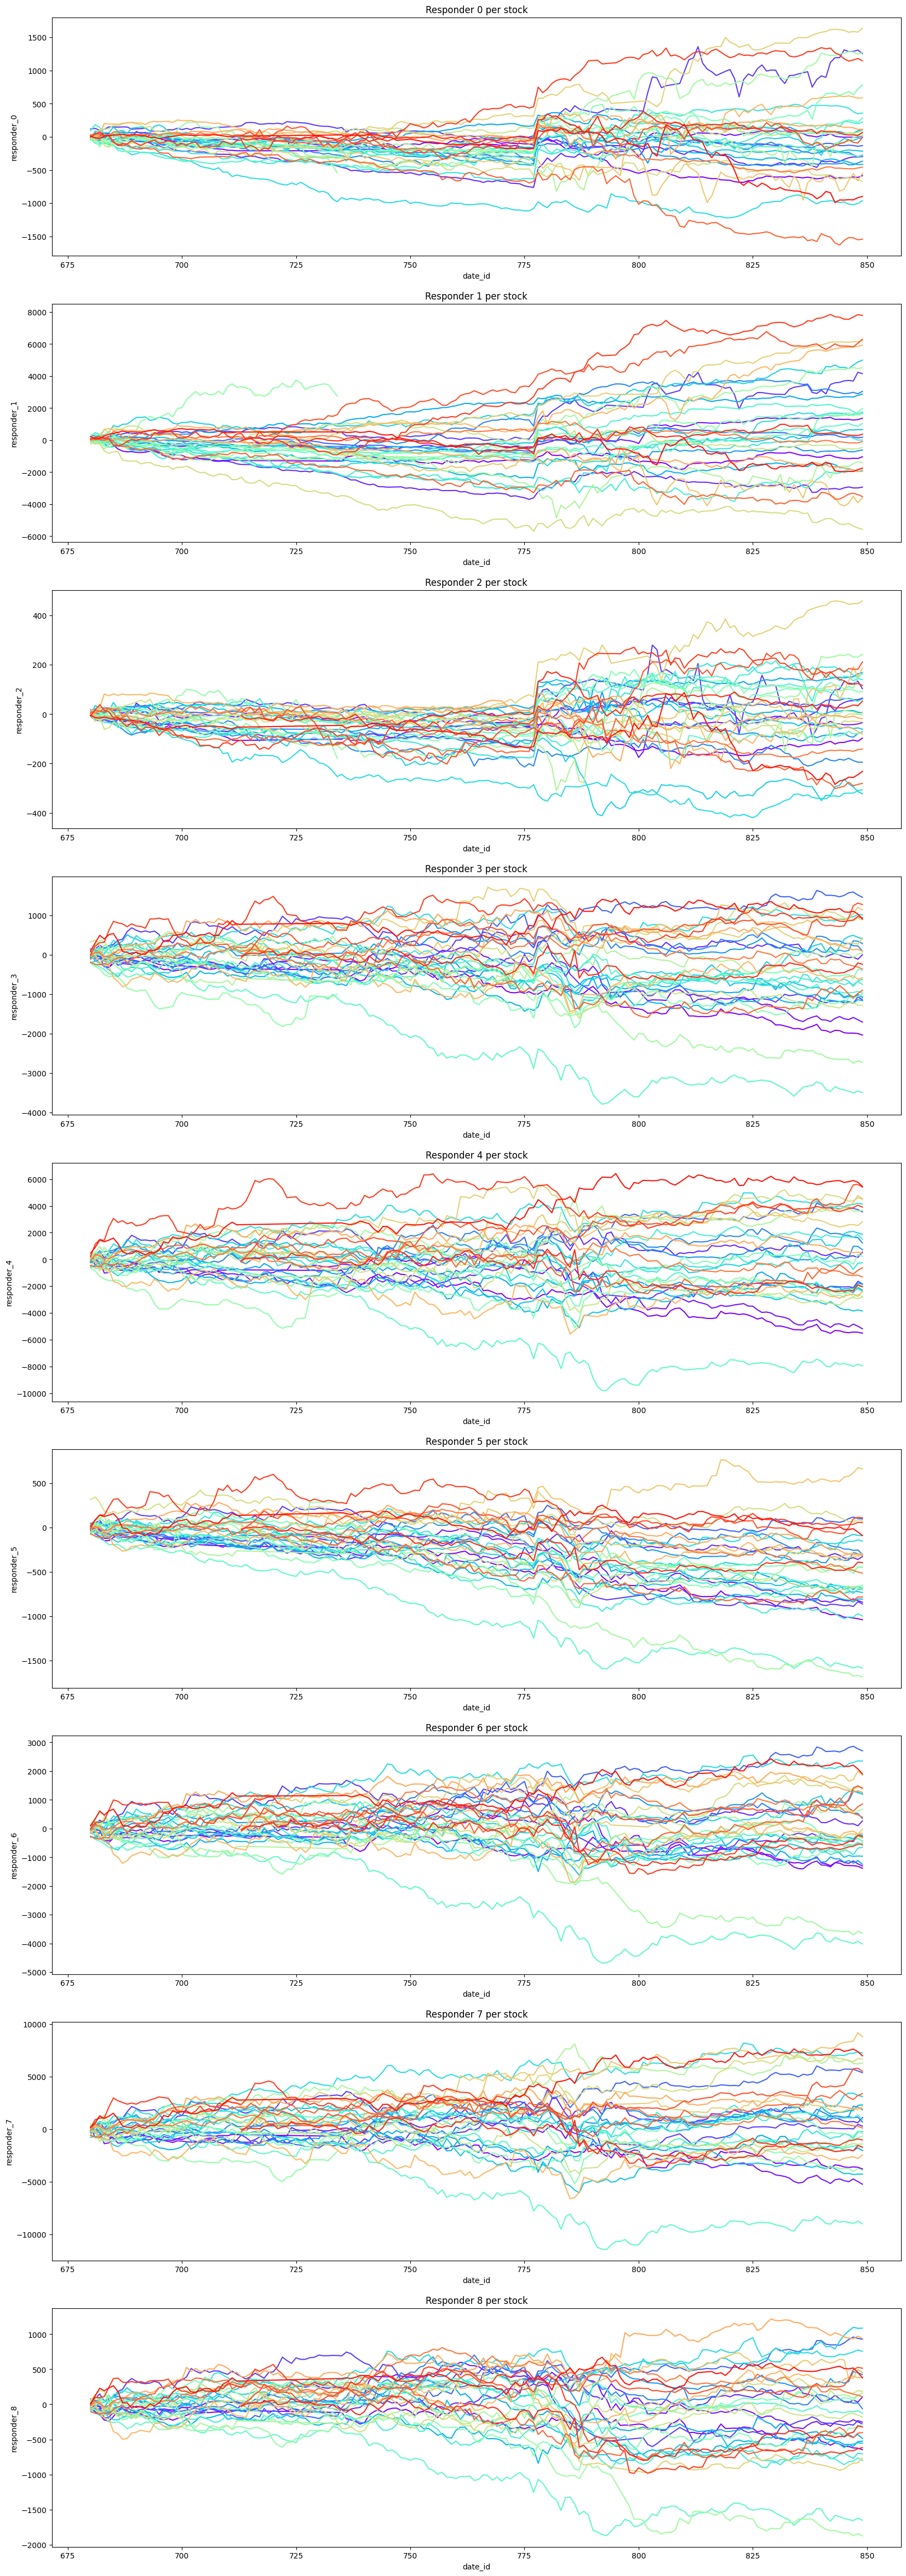

In [20]:
from matplotlib import cm

daily_responders = responders.group_by(['date_id', 'symbol_id']).agg(pl.col(RESPONDERS).sum())

colors = [cm.rainbow(i / 39)[:3] for i in range(39)]
fig, axes = plt.subplots(9, 1, figsize=(20, 60))

for i in range(9):
    for j in range(39):
        stock_data = daily_responders.filter(pl.col('symbol_id') == j).sort('date_id')
        axes[i].plot(stock_data['date_id'].to_numpy(), stock_data[f'responder_{i}'].to_numpy().cumsum(), color=colors[j])
    axes[i].set_xlabel('date_id')
    axes[i].set_ylabel(f'responder_{i}')
    axes[i].set_title(f'Responder {i} per stock')
    
plt.show()

In [21]:
time_responders = responders.group_by(['date_id', 'time_id']).agg(pl.col(RESPONDERS).sum())
time_responders.head()

shape: (5, 11)
┌─────────┬─────────┬────────────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ responder_ ┆ responder_ ┆ … ┆ responder_ ┆ responder ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ 0          ┆ 1          ┆   ┆ 5          ┆ _6        ┆ _7        ┆ _8        │
│ i16     ┆ i16     ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ---       ┆ ---       ┆ ---       │
│         ┆         ┆ f32        ┆ f32        ┆   ┆ f32        ┆ f32       ┆ f32       ┆ f32       │
╞═════════╪═════════╪════════════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 736     ┆ 793     ┆ -1.713096  ┆ -1.824134  ┆ … ┆ 10.854647  ┆ 13.622396 ┆ -1.503042 ┆ 19.847872 │
│ 839     ┆ 293     ┆ -1.693482  ┆ 0.47906    ┆ … ┆ 1.504577   ┆ 4.270819  ┆ 1.927818  ┆ 2.144042  │
│ 845     ┆ 848     ┆ 0.156686   ┆ 2.659765   ┆ … ┆ 8.545254   ┆ 1.572145  ┆ 0.752012  ┆ 14.710047 │
│ 729     ┆ 815     ┆ -2.972154  ┆ -1.104351  ┆ … ┆ 4.896787   ┆ 11.015539 ┆ 8.638565  ┆ 8.055316  │
│ 790     ┆ 949     ┆ -2.768127  ┆ 16.090199  ┆ … ┆ -18.815071 ┆ -0.452794 ┆ -3.073327 ┆ -24.79410 │
│         ┆         ┆            ┆            ┆   ┆            ┆           ┆           ┆ 2         │
└─────────┴─────────┴────────────┴────────────┴───┴────────────┴───────────┴───────────┴───────────┘

Responder 6 is not zero-sum at the same time (not normalized w.r.t. the market)

<Axes: ylabel='Count'>

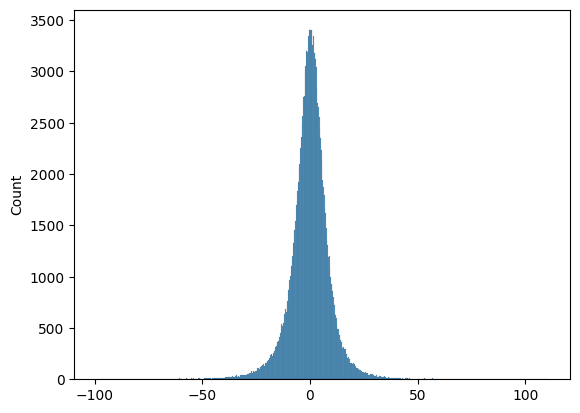

In [22]:
sns.histplot(time_responders['responder_6'].to_numpy())

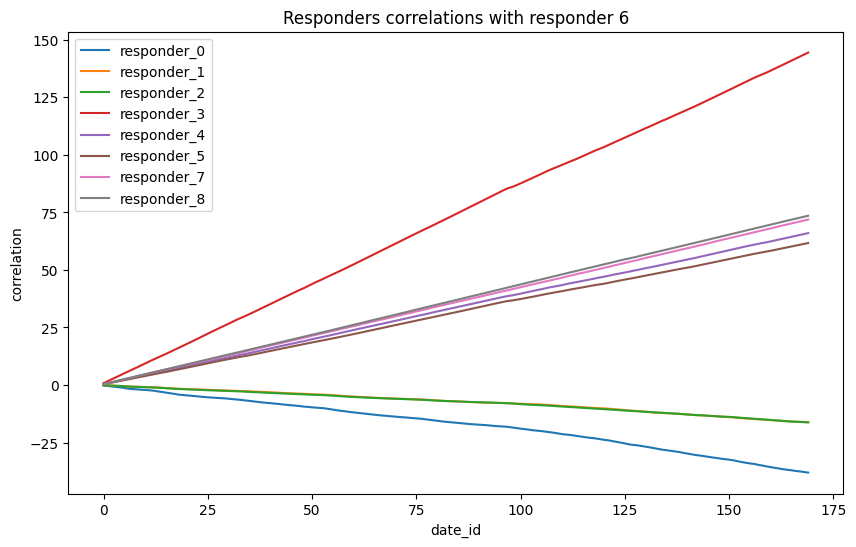

In [23]:
daily_cumulative_correlations = responders.group_by('date_id').agg(
    pl.corr(f'responder_{i}', 'responder_6') for i in range(9) if i != 6
).sort('date_id').with_columns(pl.col(f'responder_{i}').cum_sum() for i in range(9) if i != 6)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    if i != 6:
        ax.plot(daily_cumulative_correlations[f'responder_{i}'], label=f'responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Responders correlations with responder 6')
ax.legend()
plt.show()

# Lagged Responders

In [24]:
responders = train_ds.select(['date_id', 'time_id', 'symbol_id'] + [f'responder_{i}' for i in range(9)])

agg_responders = responders.group_by(['date_id', 'symbol_id']).agg(
    [pl.col(f'responder_{i}').sum().alias(f'total_responder_{i}') for i in range(9)] + \
    [pl.col(f'responder_{i}').mean().alias(f'mean_responder_{i}') for i in range(9)]
).with_columns(pl.col('date_id').add(1))
one_day_lagged_responders = responders.with_columns(pl.col('date_id').add(1))

responders = responders.join(agg_responders, on=['date_id', 'symbol_id'], how='left') \
    .join(one_day_lagged_responders, on=['date_id', 'time_id', 'symbol_id']) \
    .rename({f'responder_{i}_right': f'responder_{i}_lag_daily' for i in range(9)}) \
    .sort(['date_id', 'time_id', 'symbol_id'])
responders.tail(5)

shape: (5, 39)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0          ┆   ┆ 5_lag_dail ┆ 6_lag_dail ┆ _7_lag_da ┆ _8_lag_da │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ y          ┆ y          ┆ ily       ┆ ily       │
│         ┆         ┆           ┆ f32        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆            ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 849     ┆ 967     ┆ 34        ┆ 1.11188    ┆ … ┆ -0.897858  ┆ 0.284255   ┆ 0.124356  ┆ 0.4847    │
│ 849     ┆ 967     ┆ 35        ┆ 0.765486   ┆ … ┆ -0.216272  ┆ 0.053763   ┆ 0.043121  ┆ 0.076783  │
│ 849     ┆ 967     ┆ 36        ┆ -0.008548  ┆ … ┆ -0.588793  ┆ -1.600701  ┆ -0.599895 ┆ -3.02975  │
│ 849     ┆ 967     ┆ 37        ┆ 0.967296   ┆ … ┆ 0.467568   ┆ 0.365648   ┆ 0.296955  ┆ 0.934788  │
│ 849     ┆ 967     ┆ 38        ┆ 0.043657   ┆ … ┆ 0.485015   ┆ 0.854372   ┆ 0.42876   ┆ 1.480614  │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

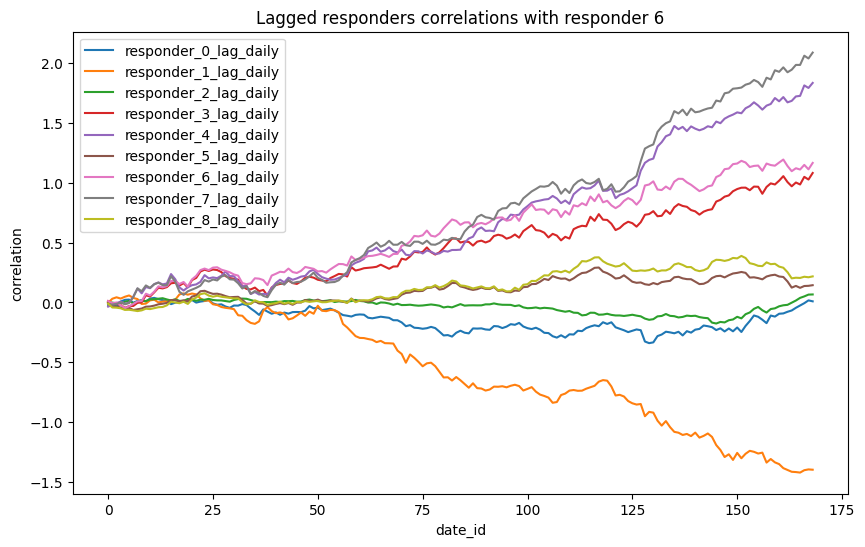

In [25]:
daily_cumulative_correlations = responders.group_by('date_id').agg(
    pl.corr(f'responder_{i}_lag_daily', 'responder_6') for i in range(9)
).sort('date_id').with_columns(pl.col(f'responder_{i}_lag_daily').cum_sum() for i in range(9))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'responder_{i}_lag_daily'], label=f'responder_{i}_lag_daily')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Lagged responders correlations with responder 6')
ax.legend()
plt.show()

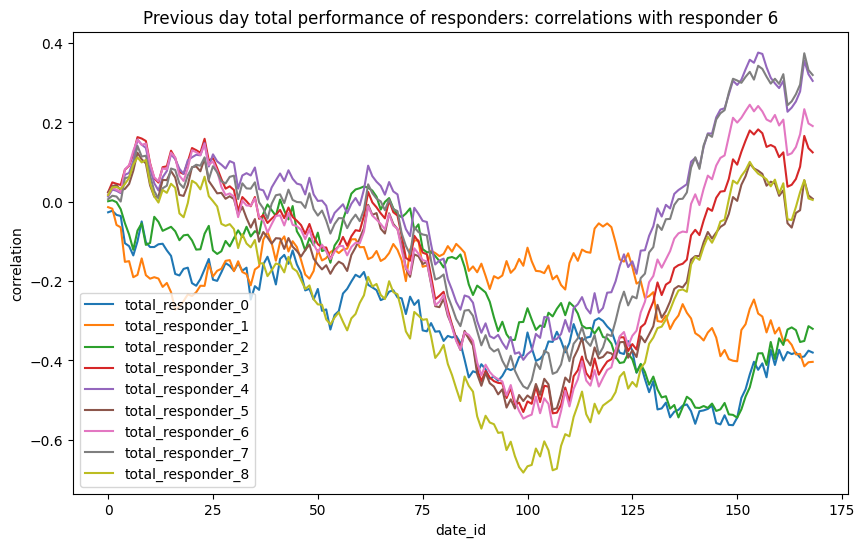

In [26]:
daily_cumulative_correlations = responders.group_by('date_id').agg(
    pl.corr(f'total_responder_{i}', 'responder_6') for i in range(9)
).sort('date_id').with_columns(pl.col(f'total_responder_{i}').cum_sum() for i in range(9))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'total_responder_{i}'], label=f'total_responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Previous day total performance of responders: correlations with responder 6')
ax.legend()
plt.show()

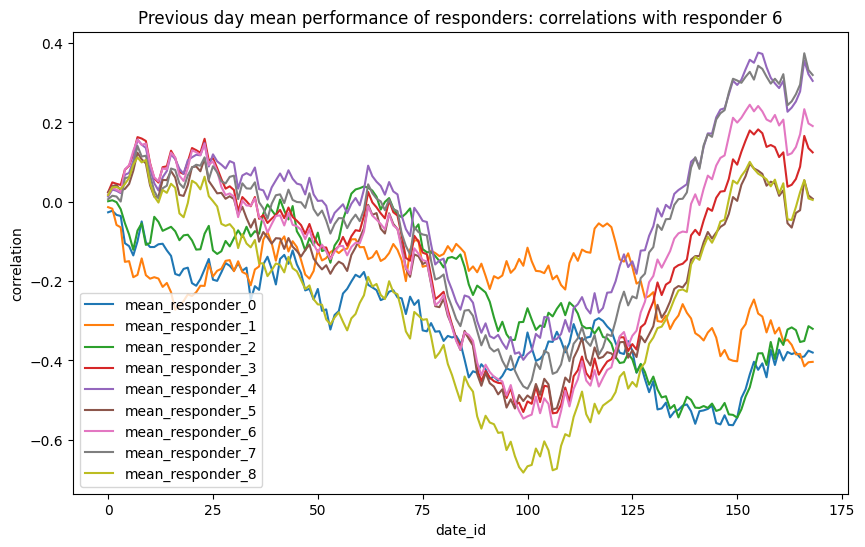

In [27]:
daily_cumulative_correlations = responders.group_by('date_id').agg(
    pl.corr(f'mean_responder_{i}', 'responder_6') for i in range(9)
).sort('date_id').with_columns(pl.col(f'mean_responder_{i}').cum_sum() for i in range(9))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'mean_responder_{i}'], label=f'mean_responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Previous day mean performance of responders: correlations with responder 6')
ax.legend()
plt.show()

In [28]:
weekly_performances = responders.group_by(['date_id', 'symbol_id']).agg(
    [pl.col(f'responder_{i}_lag_daily').sum().alias(f'daily_performance_responder_{i}') for i in range(9)] + \
    [pl.col('time_id').count().alias('num_times')]
).with_columns(
    [pl.col(f'daily_performance_responder_{i}').rolling_sum(7, min_periods=1).alias(f'weekly_performance_responder_{i}') for i in range(9)] + \
    [pl.col('num_times').rolling_sum(7, min_periods=1).alias('num_times_week')]
).with_columns(
    pl.col(f'weekly_performance_responder_{i}').truediv('num_times_week').alias(f'weekly_mean_performance_responder_{i}') for i in range(9)
)
weekly_performances.tail()

shape: (5, 31)
┌─────────┬───────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ date_id ┆ symbol_id ┆ daily_perf ┆ daily_per ┆ … ┆ weekly_me ┆ weekly_me ┆ weekly_me ┆ weekly_me │
│ ---     ┆ ---       ┆ ormance_re ┆ formance_ ┆   ┆ an_perfor ┆ an_perfor ┆ an_perfor ┆ an_perfor │
│ i16     ┆ i8        ┆ sponder_0  ┆ responder ┆   ┆ mance_res ┆ mance_res ┆ mance_res ┆ mance_res │
│         ┆           ┆ ---        ┆ _1        ┆   ┆ pon…      ┆ pon…      ┆ pon…      ┆ pon…      │
│         ┆           ┆ f32        ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│         ┆           ┆            ┆ f32       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═════════╪═══════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 803     ┆ 10        ┆ -70.196152 ┆ -377.7398 ┆ … ┆ 0.009806  ┆ 0.063623  ┆ 0.136673  ┆ 0.025638  │
│         ┆           ┆            ┆ 38        ┆   ┆           ┆           ┆           ┆           │
│ 700     ┆ 14        ┆ -2.101735  ┆ 15.090924 ┆ … ┆ 0.011314  ┆ 0.074522  ┆ 0.170536  ┆ 0.028277  │
│ 708     ┆ 22        ┆ 11.826727  ┆ 80.545837 ┆ … ┆ 0.008911  ┆ 0.082508  ┆ 0.20427   ┆ 0.026365  │
│ 745     ┆ 37        ┆ -12.404766 ┆ 82.086052 ┆ … ┆ 0.01541   ┆ 0.104032  ┆ 0.264584  ┆ 0.037294  │
│ 845     ┆ 26        ┆ -31.123587 ┆ -189.0546 ┆ … ┆ 0.012902  ┆ 0.09703   ┆ 0.261185  ┆ 0.032669  │
│         ┆           ┆            ┆ 57        ┆   ┆           ┆           ┆           ┆           │
└─────────┴───────────┴────────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

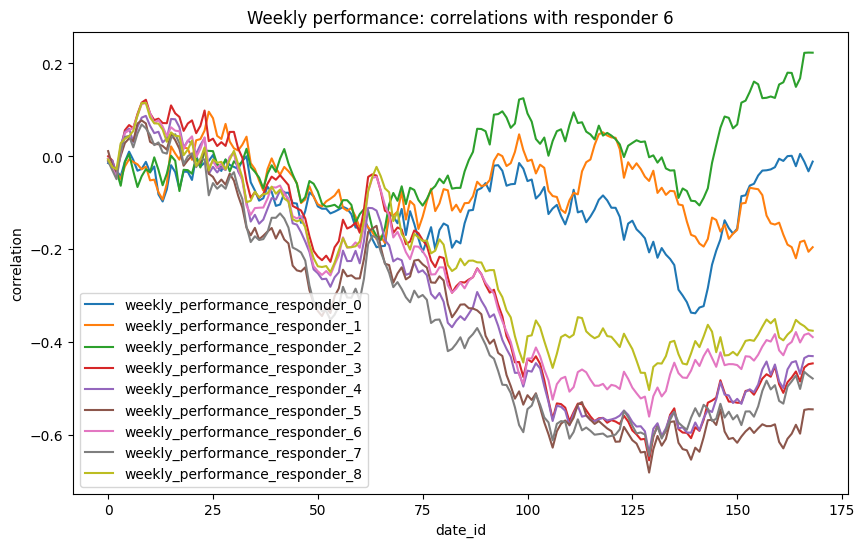

In [29]:
daily_cumulative_correlations = responders \
    .join(weekly_performances, on=['symbol_id', 'date_id']).group_by('date_id').agg(
        [pl.corr(f'weekly_performance_responder_{i}', 'responder_6') for i in range(9)] + \
        [pl.corr(f'weekly_mean_performance_responder_{i}', 'responder_6') for i in range(9)]
    ).sort('date_id')\
    .with_columns(
        *[pl.col(f'weekly_performance_responder_{i}').cum_sum() for i in range(9)],
        *[pl.col(f'weekly_mean_performance_responder_{i}').cum_sum() for i in range(9)]
    )

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'weekly_performance_responder_{i}'], label=f'weekly_performance_responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Weekly performance: correlations with responder 6')
ax.legend()
plt.show()

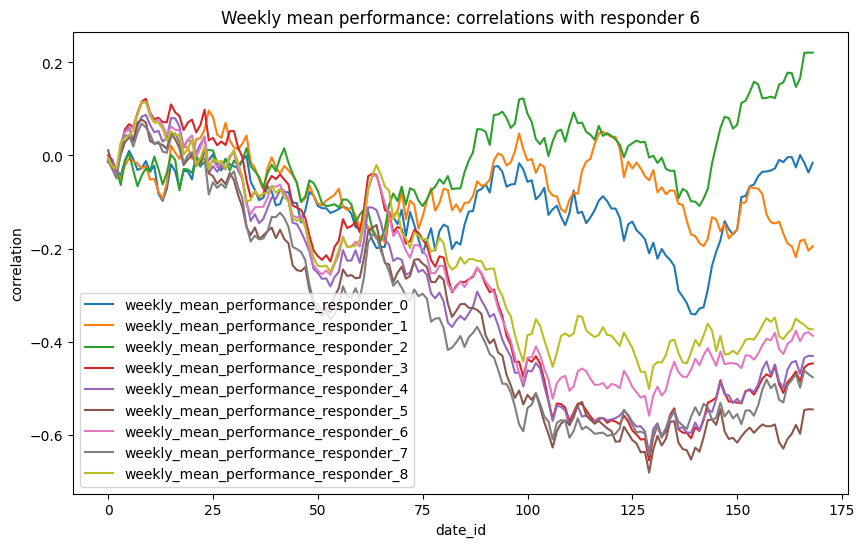

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'weekly_mean_performance_responder_{i}'], label=f'weekly_mean_performance_responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Weekly mean performance: correlations with responder 6')
ax.legend()
plt.show()

In [31]:
responders = responders.sort(['date_id', 'time_id', 'symbol_id'])
responders.head(3)

shape: (3, 39)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0          ┆   ┆ 5_lag_dail ┆ 6_lag_dail ┆ _7_lag_da ┆ _8_lag_da │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ y          ┆ y          ┆ ily       ┆ ily       │
│         ┆         ┆           ┆ f32        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆            ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 681     ┆ 0       ┆ 0         ┆ -0.070765  ┆ … ┆ 0.375675   ┆ 0.929775   ┆ -1.574939 ┆ 1.101371  │
│ 681     ┆ 0       ┆ 1         ┆ -0.398183  ┆ … ┆ 0.777026   ┆ 0.826995   ┆ 0.569681  ┆ 1.986971  │
│ 681     ┆ 0       ┆ 2         ┆ -2.145016  ┆ … ┆ -0.123519  ┆ -0.296969  ┆ 0.547286  ┆ -0.049303 │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

In [32]:
features = [f'responder_{i}_lag_daily' for i in range(9)] + [f'total_responder_{i}' for i in range(9)] + [f'mean_responder_{i}' for i in range(9)]
target = 'responder_6'
daily_corr = responders.group_by(['date_id']).agg(
    pl.corr(f, target).name.keep() for f in features
).with_columns(
    #Flip sign for negative mean correlation since we only care about magnitude
    pl.all().exclude('date_id').mul(pl.all().exclude('date_id').mean().sign()).name.keep()
).sort('date_id')
daily_corr

shape: (169, 28)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ date_id ┆ responder_ ┆ responder ┆ responder ┆ … ┆ mean_resp ┆ mean_resp ┆ mean_resp ┆ mean_resp │
│ ---     ┆ 0_lag_dail ┆ _1_lag_da ┆ _2_lag_da ┆   ┆ onder_5   ┆ onder_6   ┆ onder_7   ┆ onder_8   │
│ i16     ┆ y          ┆ ily       ┆ ily       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│         ┆ ---        ┆ ---       ┆ ---       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
│         ┆ f64        ┆ f64       ┆ f64       ┆   ┆           ┆           ┆           ┆           │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 681     ┆ -0.021904  ┆ 0.00317   ┆ -0.003188 ┆ … ┆ 0.023474  ┆ 0.017899  ┆ 0.006375  ┆ 0.016662  │
│ 682     ┆ 0.006854   ┆ -0.033207 ┆ 0.000922  ┆ … ┆ 0.015616  ┆ 0.016909  ┆ 0.008643  ┆ 0.019444  │
│ 683     ┆ -0.020696  ┆ -0.011993 ┆ -0.005718 ┆ … ┆ 0.002927  ┆ -0.004676 ┆ -0.002079 ┆ 0.000913  │
│ 684     ┆ 0.042064   ┆ 0.010499  ┆ -0.002997 ┆ … ┆ -0.013314 ┆ -0.005913 ┆ -0.012647 ┆ -0.004996 │
│ 685     ┆ 0.014556   ┆ -0.015074 ┆ 0.015602  ┆ … ┆ 0.003495  ┆ 0.057362  ┆ 0.058767  ┆ 0.012419  │
│ …       ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 845     ┆ 0.022407   ┆ 0.002403  ┆ 0.017726  ┆ … ┆ 0.036774  ┆ 0.015484  ┆ 0.017876  ┆ 0.032853  │
│ 846     ┆ 0.018897   ┆ 0.004335  ┆ 0.022219  ┆ … ┆ 0.006975  ┆ 0.032368  ┆ 0.024396  ┆ 0.037636  │
│ 847     ┆ 0.019744   ┆ -0.019919 ┆ 0.012385  ┆ … ┆ 0.075414  ┆ 0.063167  ┆ 0.078904  ┆ 0.030197  │
│ 848     ┆ 0.023401   ┆ -0.006607 ┆ 0.014979  ┆ … ┆ -0.038154 ┆ -0.036001 ┆ -0.042395 ┆ -0.046216 │
│ 849     ┆ -0.007983  ┆ 0.002524  ┆ 0.001231  ┆ … ┆ -0.008318 ┆ -0.00652  ┆ -0.012457 ┆ -0.003779 │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [33]:
def metrics(corr):
    corr_mean = corr.mean()
    corr_std = corr.std(ddof=0)
    corr_sharpe = corr_mean / corr_std
    max_drawdown = -(corr.cumsum().expanding(min_periods=1).max() - corr.cumsum()).max()

    eras = daily_corr['date_id'].unique().sort().to_list()
    halfway_era = len(eras)//2
    corr_mean_first_half = corr.loc[eras[:halfway_era]].mean()
    corr_mean_second_half = corr.loc[eras[halfway_era:]].mean()

    delta = abs(corr_mean_first_half - corr_mean_second_half)

    return {
      "mean": corr_mean,
      "std": corr_std,
      "sharpe": corr_sharpe,
      "max_drawdown": max_drawdown,
      "delta": delta
    }

per_era_corr = daily_corr.to_pandas().set_index('date_id')
# compute performance metrics for each feature
feature_metrics = [
    metrics(per_era_corr[feature_name])
    for feature_name in features
]

# convert to numeric DataFrame and sort
feature_metrics = (
    pd.DataFrame(feature_metrics, index=features)
    .apply(pd.to_numeric)
    .sort_values("mean", ascending=False)
)

feature_metrics

mean       std    sharpe  max_drawdown     delta
responder_7_lag_daily  0.012362  0.035432  0.348884     -0.184859  0.012036
responder_4_lag_daily  0.010860  0.033182  0.327293     -0.192169  0.011226
responder_1_lag_daily  0.008285  0.030347  0.273008     -0.189452  0.001679
responder_6_lag_daily  0.006900  0.032445  0.212663     -0.148978  0.002416
responder_3_lag_daily  0.006402  0.029574  0.216484     -0.219113  0.000074
total_responder_1      0.002389  0.028103  0.085005     -0.217722  0.002232
mean_responder_1       0.002389  0.028103  0.085005     -0.217722  0.002232
total_responder_0      0.002250  0.028120  0.080010     -0.190076  0.003534
mean_responder_0       0.002250  0.028120  0.080010     -0.190076  0.003534
total_responder_2      0.001896  0.025921  0.073149     -0.230633  0.000358
mean_responder_2       0.001896  0.025921  0.073149     -0.230633  0.000358
mean_responder_7       0.001889  0.030273  0.062405     -0.612232  0.010754
total_responder_7      0.001889  0.030273  0.062405     -0.612232  0.010754
mean_responder_4       0.001802  0.029930  0.060190     -0.555202  0.009559
total_responder_4      0.001802  0.029930  0.060190     -0.555202  0.009559
responder_8_lag_daily  0.001284  0.017670  0.072653     -0.187558  0.001577
mean_responder_6       0.001128  0.030555  0.036910     -0.724631  0.010556
total_responder_6      0.001128  0.030555  0.036910     -0.724631  0.010556
responder_5_lag_daily  0.000848  0.016208  0.052336     -0.170001  0.002132
mean_responder_3       0.000735  0.030360  0.024218     -0.696085  0.009605
total_responder_3      0.000735  0.030360  0.024218     -0.696085  0.009605
responder_2_lag_daily  0.000390  0.010831  0.035972     -0.211601  0.001446
responder_0_lag_daily  0.000049  0.021341  0.002303     -0.378520  0.006128
mean_responder_5       0.000044  0.029749  0.001469     -0.647179  0.008335
total_responder_5      0.000044  0.029749  0.001469     -0.647179  0.008335
total_responder_8      0.000026  0.030032  0.000856     -0.794476  0.011191
mean_responder_8       0.000026  0.030032  0.000856     -0.794476  0.011191

array([[<Axes: title={'center': 'mean'}>,
        <Axes: title={'center': 'std'}>,
        <Axes: title={'center': 'sharpe'}>],
       [<Axes: title={'center': 'max_drawdown'}>,
        <Axes: title={'center': 'delta'}>, <Axes: >]], dtype=object)

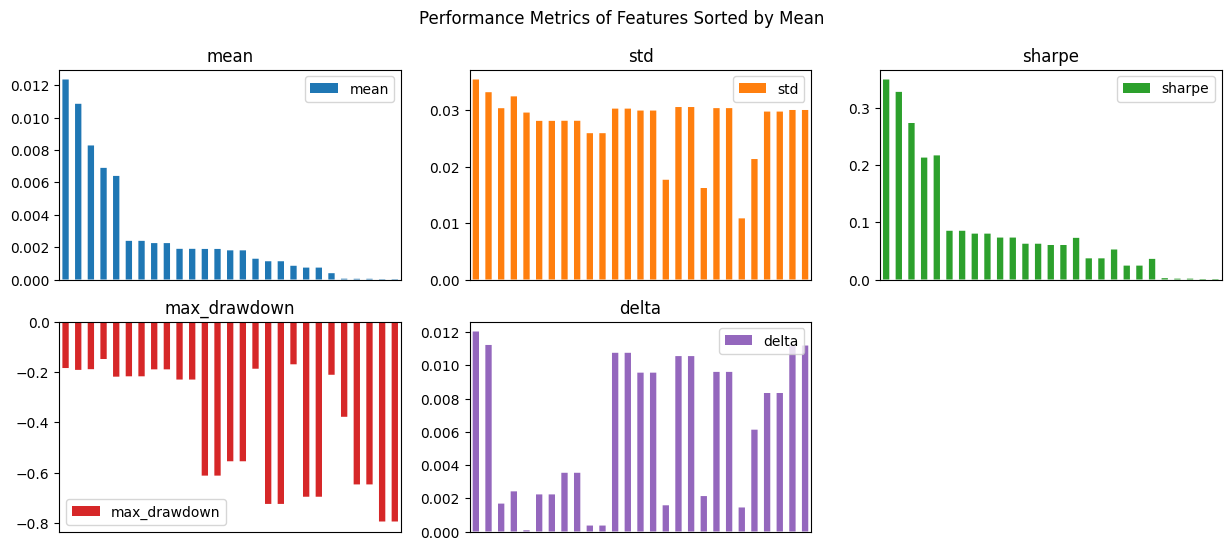

In [34]:
feature_metrics.sort_values("mean", ascending=False).plot.bar(
    title="Performance Metrics of Features Sorted by Mean",
    subplots=True,
    figsize=(15, 6),
    layout=(2, 3),
    sharex=False,
    xticks=[],
    snap=False
)

In [35]:
metric="std"
min_f, max_f = feature_metrics[metric].idxmin(), feature_metrics[metric].idxmax()
per_era_corr[[min_f, max_f]].cumsum().plot(
    figsize=(15, 5), title="Cumulative Correlation of Features to the Target", xlabel="Day"
)
plt.legend([f"lowest {metric}: {min_f}", f"highest {metric}: {max_f}"])

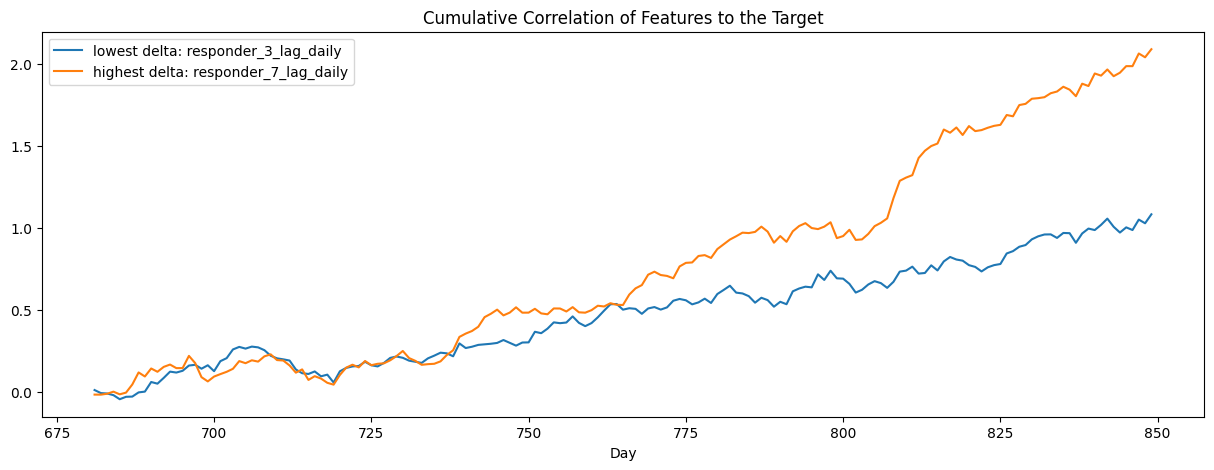

In [36]:
metric="delta"
min_f, max_f = feature_metrics[metric].idxmin(), feature_metrics[metric].idxmax()
per_era_corr[[min_f, max_f]].cumsum().plot(
    figsize=(15, 5), title="Cumulative Correlation of Features to the Target", xlabel="Day"
)
plt.legend([f"lowest {metric}: {min_f}", f"highest {metric}: {max_f}"])

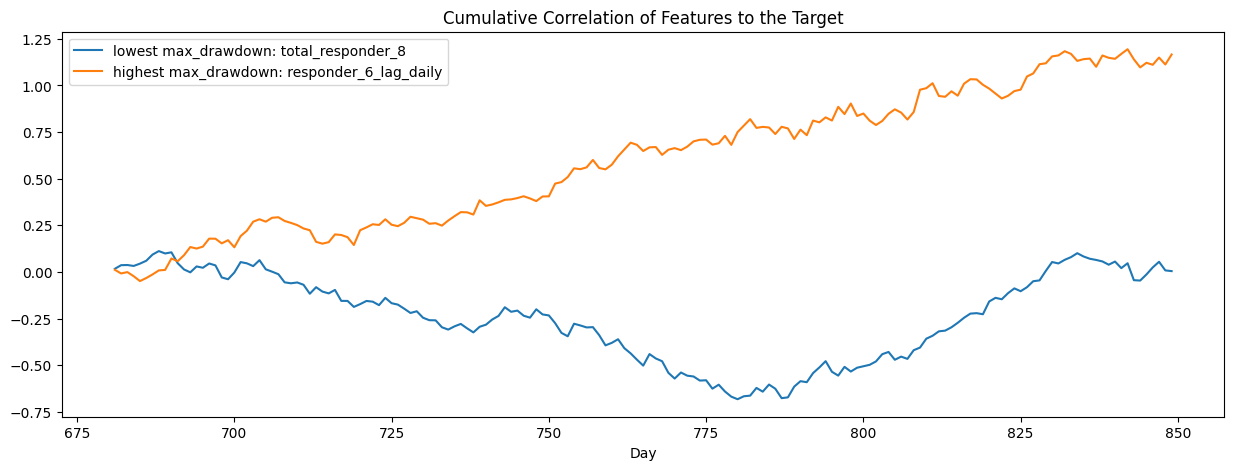

In [37]:
metric="max_drawdown"
min_f, max_f = feature_metrics[metric].idxmin(), feature_metrics[metric].idxmax()
per_era_corr[[min_f, max_f]].cumsum().plot(
    figsize=(15, 5), title="Cumulative Correlation of Features to the Target", xlabel="Day"
)
plt.legend([f"lowest {metric}: {min_f}", f"highest {metric}: {max_f}"])